## Online Retail - K-Means Clustering and Hierarchical Clustering

**Overview**<br>
Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and recommendations

# 1. Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# read the dataset
retail_df = pd.read_csv("Online_Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 2. Clean the data

In [4]:
# Checking for null or missing values
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

- The column CustomerID has approximately 24.93% missing values. This implies that almost a quarter of the rows in the dataset do not have a CustomerID. Dropping rows based on missing CustomerID values will result in the loss of 25% of the dataset, which could be significant.


- The column Description has a minor 0.27% missing values. Since only 0.27% of the rows have missing Description values, it's feasible to drop those rows without losing a significant amount of data.


In [6]:
retail_df.shape

(541909, 8)

In [7]:
# dropping rows where 'Description' column has missing values of only 0.27% of the data.

#retail_df = retail_df.dropna()

retail_df = retail_df.dropna(subset=['Description'])
retail_df.shape

(540455, 8)

In [8]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.00
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.72
Country         0.00
dtype: float64

In [9]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


# 3. Prepare the data for modelling

#### RFM Analysis: 

- R (Recency): Number of days since last purchase.
- F (Frequency): Number of transactions.
- M (Monetary): Total amount of transactions (revenue contributed).

We need to now create three new columns or three new features. So we are deriving these new metrics to do clustering. 

In [10]:
# new column: amount 
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


Now we can use this quantity column.

In [11]:
# M (monetary)

# Let's groupby the customerid and add up the amount of transactions, we get the monetary of each customer, that is total
# revenue contributed by each customer
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()

# Don't want CustomerID as an Index for each row, want it as a column
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


For each CustomerID, you have total amount of revenue contributed.

In [12]:
# F (frequency) count of transaction a particular customer has done.
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Count of transaction a particular customer has done.

In [13]:
# merge the two dfs
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


Inner merge will only consider CustomerIDs which are common in the both of these dataframes. Only those customers will be part of the final dataframe, which are in both the dataframes. 

In [14]:
retail_df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France,14.85


### Recency: Number of days since last purchase

For example, taking 9th December as the reference date, suppose customer-3: has a total of 5 transactions:

(1) First transaction - 300 days ago <br>
(2) Second transaction - 200 days ago <br>
(3) Third transaction - 50 days ago <br>
(4) Fourth transaction - 10 days ago <br>
(5) Fifth transaction - 4 days ago <br>

In [15]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540455 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    540455 non-null  object 
 1   StockCode    540455 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     540455 non-null  int64  
 4   InvoiceDate  540455 non-null  object 
 5   UnitPrice    540455 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      540455 non-null  object 
 8   amount       540455 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 41.2+ MB


`InvoiceDate` is a string(object). We want date type column.

In [16]:
# recency
# convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

In [17]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540455 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    540455 non-null  object        
 1   StockCode    540455 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     540455 non-null  int64         
 4   InvoiceDate  540455 non-null  datetime64[ns]
 5   UnitPrice    540455 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      540455 non-null  object        
 8   amount       540455 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 41.2+ MB


In [18]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [19]:
# compute the max date
max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

Now we compute the difference between each transaction and the max date. So, we create a new column diff

In [20]:
# compute the diff
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [21]:
# recency
last_purchase = retail_df.groupby('CustomerID')['diff'].min() # the minimum of this would be recency of this customer
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [22]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


Looking at the recency variable right now, it is in the number of days and hours, but the purpose of clustering and customer segmentation in general, we want don't want hours at this granular level. We will probably suffice if we have number of days as the last transaction. We don't want the hours and minutes. 

In [23]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### Outlier Treatment


Two types of outliers:
- domain specific outliers: are those you label a point as an outlier based on the domain knowledge. For example, you could go to the online retailer and show the amount outlier and ask does this look unusual. If you look at the amount outlier, the points are unexpected extreme points. If 5% customer contributes $200,000, you can't say it is an outlier because these 5% customers contributes. So, they should be in a cluster. You shouldn't say, they are outliers, otherwise you will lose an important peace of information. In domain specific outliers, you label something as an outlier based on the domain expertise. You ask client does this look extremely unusual. <br>


- statistical outliers: defined using the interquartile range that is anything more than 98th percentile or below the second or fifth percentile is called an outlier. The essence of statistical outlier is that you don't really care about the variables itself or the meaning of the variable. For example, more than 98th percentile means it is an outlier.



{'whiskers': [<matplotlib.lines.Line2D at 0x1f2cb9249a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f2cb924ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f2cb924700>],
 'medians': [<matplotlib.lines.Line2D at 0x1f2cb90f460>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f2cb90f700>],
 'means': []}

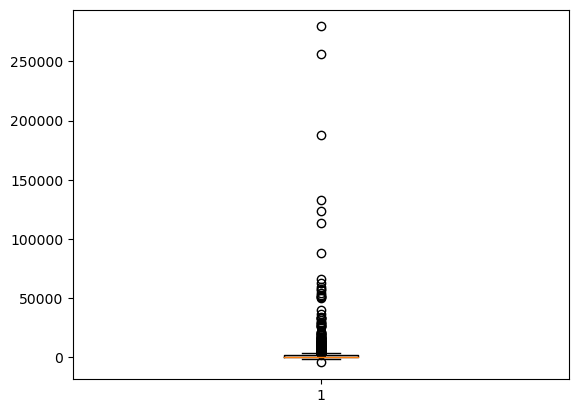

In [24]:
# outlier treatment
plt.boxplot(grouped_df['amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f2cba5b1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f2cba5b700>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f2cba49ee0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f2cba5bc40>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f2cba5bee0>],
 'means': []}

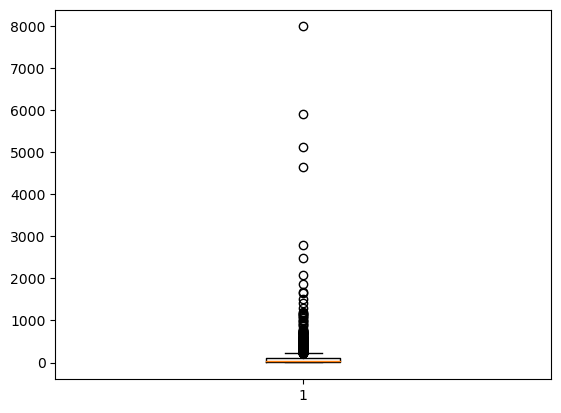

In [25]:
# outlier treatment
plt.boxplot(grouped_df['frequency'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f2cba89d60>,
 'caps': [<matplotlib.lines.Line2D at 0x1f2cba992e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f2cba89be0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f2cba99820>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f2cba99af0>],
 'means': []}

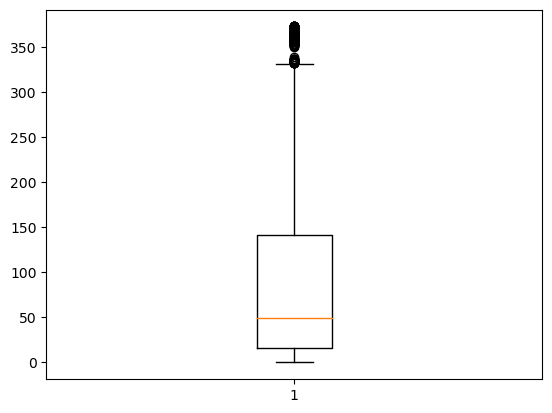

In [26]:
# outlier treatment
plt.boxplot(grouped_df['recency'])

In [27]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



The provided code snippet is applying a modified version of the Interquartile Range (IQR) method to filter out statistical outliers from a dataset stored in a Pandas DataFrame named `grouped_df`. Here’s a breakdown of the code:

1. **Calculating the Quantiles**:
    - `Q1 = grouped_df.amount.quantile(0.05)`: This line calculates the 5th percentile (instead of the usual 25th percentile for the lower quartile) of the `amount` column in the DataFrame `grouped_df`.
    - `Q3 = grouped_df.amount.quantile(0.95)`: This line calculates the 95th percentile (instead of the usual 75th percentile for the upper quartile) of the `amount` column in the DataFrame `grouped_df`.

2. **Calculating the Interquartile Range (IQR)**:
    - `IQR = Q3 - Q1`: This line computes the interquartile range, which is the difference between the 95th percentile (`Q3`) and the 5th percentile (`Q1`) of the data in the `amount` column.

3. **Filtering Outliers**:
    - `grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]`: This line updates `grouped_df` by retaining only the rows where the values of the `amount` column are within the range defined by the formula \([Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]\). This is a common way of defining "fences" to identify outliers, albeit with a modified version of quartiles.

In summary, this code snippet is using a method based on the interquartile range to identify and remove statistical outliers from the `amount` column of `grouped_df`. The key modification here is that instead of using the traditional 25th and 75th percentiles for `Q1` and `Q3`, respectively, the code uses the 5th and 95th percentiles, which will result in a wider range of values being retained in the dataset.


This code snippet is performing a similar action to the previous code snippet but this time it's being applied to a different column named `recency` of the DataFrame `grouped_df`. Here's a breakdown of the code snippet:

1. **Calculating the Quantiles**:
    - `Q1 = grouped_df.recency.quantile(0.05)`: The 5th percentile of the `recency` column is calculated.
    - `Q3 = grouped_df.recency.quantile(0.95)`: The 95th percentile of the `recency` column is calculated.

2. **Calculating the Interquartile Range (IQR)**:
    - `IQR = Q3 - Q1`: The interquartile range is calculated by subtracting the 5th percentile (`Q1`) from the 95th percentile (`Q3`).

3. **Filtering Outliers**:
    - `grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]`: This line filters the DataFrame `grouped_df` to retain only the rows where the values of the `recency` column fall within the bounds defined by \([Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]\). 

This outlier detection and removal strategy is based on the Interquartile Range method but with custom percentiles (5th and 95th instead of the usual 25th and 75th). By doing this, the code aims to eliminate the extreme outliers from both ends of the distribution in the `recency` column while keeping a wider range of data compared to the traditional IQR method.

### Rescaling

Rescaling is the process of adjusting the scale of features in your dataset, making them comparable and often helping machine learning algorithms perform better. There are multiple methods to achieve this, but the two most common methods are:

1. <b>standardization:</b> 
- In this method, the features are rescaled so that they have the properties of a standard normal distribution with a mean (µ) of 0 and a standard deviation (σ) of 1.

- The formula for standardization is:
$
Z = \frac{X - µ}{σ} 
$

where:
Z is the standardized value,
X is the original value,
µ is the mean of the feature, and
σ is the standard deviation of the feature.     

- After standardization, the distribution of the feature will have a mean of 0 and a standard deviation of 1.

2. <b>Normalization (Min-Max Scaling)</b>: 
- In this method, the features are rescaled to lie between a given minimum and maximum value, usually between 0 and 1.

- The formula for min-max scaling is:
$
X′ = \frac{X - x_{\min}}{x_{\max} - x_{\min}} 
$

where:
X′ is the normalized value, X is the original value, X(min) is the minimum value of the feature, and X(max) is the maximum value of the feature.

- As mentioned, normalization often scales the values between 0 and 1, but it can be adjusted to scale between any two values.

<b>Which one to choose?</b>

- The choice between standardization and normalization often depends on the context and the specific algorithms you're using.
- Some algorithms, like those based on distance computations (e.g., k-means clustering or k-nearest neighbors), might perform better with standardized or normalized data because features on larger scales won't disproportionately affect the results.
- In some cases, if the original scale of the feature has a meaningful interpretation (e.g., temperature in Celsius), normalization might be preferred.
- In other scenarios, if the algorithm assumes the data to have a Gaussian distribution (e.g., linear regression with certain conditions), standardization might be more suitable.
- Often, it's beneficial to experiment with both methods and determine which one gives better performance for your specific task.

Here, we will apply standardization.

In [28]:
# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

In [29]:
rfm_df.head()

,amount,frequency,recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [30]:
# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape



(4293, 3)

In [31]:
rfm_df_scaled

# The mean of each variable is 0, SD is 1. That's what standard scaler does.

array([[-0.72373821, -0.75288754,  2.30161144],
       [ 1.73161722,  1.04246665, -0.90646561],
       [ 0.30012791, -0.46363604, -0.18365813],
       ...,
       [-0.67769602, -0.70301659,  0.86589794],
       [-0.6231313 , -0.64317145, -0.84705678],
       [ 0.32293822, -0.07464263, -0.50050524]])

In [32]:
# convert the numpy array that you have to a dataframe
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered or to find if the dataset is suitable for clustering or not.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

Notes regarding Hopkins Statistic

- On multiple iterations of Hopkins Statistic, you would be getting multiple values since the algorithm uses some randomisation in the initialisation part of the code. Therefore it is advised to run it a couple of times before confirming whether the data is suitable for clustering or not.

In [33]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [34]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(rfm_df_scaled)

0.9526641484517809

# 4. Modelling

In [35]:
# k-means with some arbitrary k, random number 4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

- The max_iter parameter is set to 50, which means the algorithm will run a maximum of 50 iterations to find the centroids of the clusters.

- Assignment Step: During each iteration, each observation in the dataset (rfm_df_scaled) is assigned to the nearest centroid. "Nearest" is typically defined using the Euclidean distance in the feature space.

- Update Step: Once all observations have been assigned to clusters, the centroids of these clusters are recalculated as the mean of all points currently in the cluster.

- The algorithm repeats the assignment and update steps iteratively. The algorithm will stop if the assignments no longer change between iterations or if the defined max_iter (in this case, 50) is reached. If the algorithm does not converge (i.e., the assignments are still changing) after 50 iterations, it will return the clusters formed at the end of the 50th iteration.

In [36]:
# It will return the labels of all the data points
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [37]:
# 4000 data points
len(kmeans.labels_)

4293

In [38]:
# help(KMeans)

Now the question is how many clusters, a central question when you are doing K-Means clustering, which will basically becomes the number of customer segments that you have. There should be 2, 3 or 4 customer segments. 

Another important point the number of customer segments depends not only on a particular technique but of course it depends on the business objective as well. 


## Finding the Optimal Number of Clusters

To find the optimum number of clusters, we use two techniques:

- <b>The elbow curve method:</b> Create multiple clusters and then check the percentage of information that is explained in each of those clusters and after a point adding any more clusters does not seem to be beneficial, one can stop at that point. 


- <b>The silhouette score method:</b> This is a metric used to calculate the goodness of a clustering algorithm. The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The value of the silhouette score ranges between -1 and 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

### SSD (Sum of squared distances/elbow-curve)

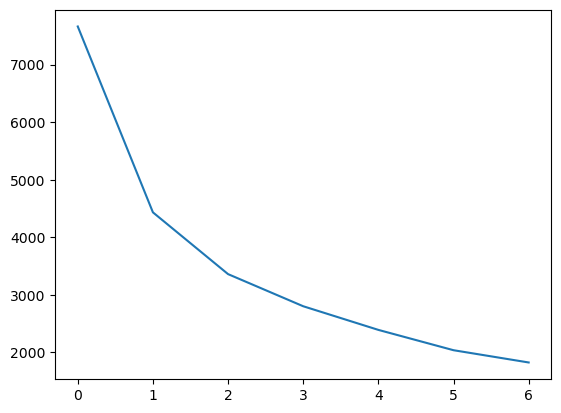

In [39]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8] # Anything more than 8 or 9 clusters from customer segmentation point of view does not look very promising.
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

0 - 2 (clusters) <br>
1 - 3 (clusters)<br>
2 - 4 (clusters)<br>
3 - 5 (clusters)<br>
4 - 6 (clusters)<br>
5 - 7 (clusters)<br>
6 - 8 (clusters)<br>

The above plot shows that when there are 3 clusters, the SSD drops significantly. Also, adding another cluster does not reduce the value of SSD significantly. 

What does basically SSD mean?<br>
Sum of squared distances to their individual samples to their closest center. As you increase the number of clusters, the value of SSD goes down. However, the question is does it goes down enough compared to previous number of clusters so that adding another cluster is justified? That is the question that one should ask and that is the reason, it is called an elbow curve because when you have 2 clusters, you have 9000 SSD. Now, when you go from 2 to 3 clusters, the SSD drops very significantly, but when you go from 3 to 4, the slope is reduced, the rate of drop is reduced (i.e SSD is not significantly reduced). Therefore, one can conclude and say that 3 seems to be good number of clusters to have.

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of. The bigger the $p$, the better it is.

$q$ is the mean intra-cluster distance to all the points in its own cluster. $q$ should be as low as possible for the clusters to be good.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the (same) cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its (same) cluster.

For example,

data point num 10 (cluster - 1) <br>
p = 100 <br>
q = 10 <br>
90/100 = 0.9

data point num 15 (cluster - 1) <br>
p = 10 <br>
q = 12 <br>
-2/12 = -1/6




A negative score indicates a very poor clustering output. It is actually closer to the data points on an average in a nearby cluster than its own cluster's data points. As we have computed sihouette score of these two data points. We will compute the silhouette score for all the data points. So, we have 4000 data points, we will compute the silhouette score of all the data points. It will be done for the multiple clusters and whichever cluster has the maximum silhouette score that is probably the optimal number of clusters. 

In [40]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_  # Why you need cluster labels? You need to tell for each data point what cluster it is a part of and then it will compute the silhouette score.
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4816531272445321
For n_clusters=5, the silhouette score is 0.46627005641897035
For n_clusters=6, the silhouette score is 0.41707885139850487
For n_clusters=7, the silhouette score is 0.415880315639633
For n_clusters=8, the silhouette score is 0.4000223850566237


The elbow curve told us that number of clusters = 3 looks like a decent option. The silhouette analysis told us that any score which is close to 1 is a good silhouette score. n_clusters = 2 seems to be the best score, but 2 must not be the most optimal number from a customer segmentation point of view or business perspective. The 2 might be too less, the client might expect a little more granular segmentation. So, in that case n_clusters = 3 is not a bad. The score should not be 0.3 or 0.2.

I am not saying that it is final optimal number of clusters, but with 3 I will go ahead and will see if that generate clusters that are interpretable by the business and which are sort of intuitive enough, otherwise we might try with 2 or may be 4. The idea is that n_clusters = 2, 3, or 4 look like a optimal range. Changes can be made whenever required. 

## Cluster Analysis 

First we need to assign the ClusterIDs that we generated to each of the datapoints that we have with us.  

In [41]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [42]:
# This is a numpy series, basically an array, one dimensional array of all the labels corresponding to each of the data points 
kmeans.labels_

array([1, 0, 2, ..., 1, 2, 2])

In [43]:
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [44]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,1


<AxesSubplot: xlabel='cluster_id', ylabel='amount'>

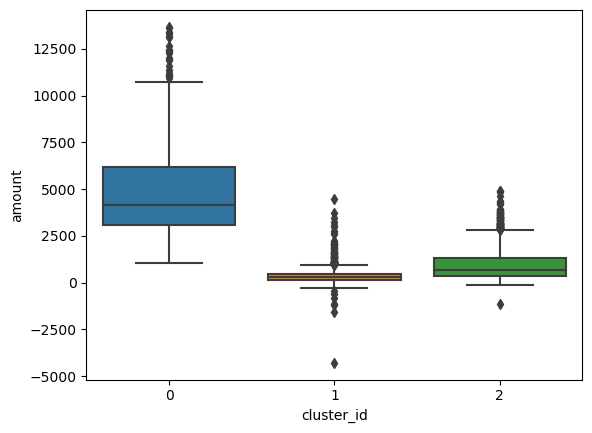

In [45]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

### Interpretation of the box plot in relation to the 'Amount':

1. **Cluster 1 (Blue Box)**
   - The customers in this cluster have a median amount (the line inside the box) which is significantly higher than the other two clusters.
   - The interquartile range (IQR), represented by the height of the box, suggests that the middle 50% of these customers have a relatively broad range of transaction amounts, but generally on the higher side.
   - There are a few outlier values at the upper end (the individual points beyond the "whisker" of the box), indicating some customers in this cluster have exceptionally high transaction amounts.
   - Overall, Cluster 0 seems to represent customers who spend more.

2. **Cluster 2 (Orange Box)**
   - The median amount for this cluster is near zero, indicating that customers in this group have an average transaction amount that is much lower.
   - The IQR is narrow, suggesting that the transaction amounts for the middle 50% of these customers are relatively consistent but on the lower side.
   - There are several outliers both above and below the whiskers, indicating a few customers with unusually high or negative transaction amounts. The negative values could represent returns or refunds.

3. **Cluster 3 (Green Box)**
   - The median amount is higher than Cluster 1 but lower than Cluster 0.
   - The IQR suggests that the middle 50% of these customers have transaction amounts that span a moderate range.
   - There are a few outliers on the upper side, suggesting a small number of customers with notably high transaction amounts.

**General Interpretation**: 
- Customers in Cluster 1 tend to contribute the highest revenue, making them possibly the most valuable segment in terms of monetary contribution.
- Customers in Cluster 2 seem to have the least spending, with some even having negative values, possibly indicating refunds or returns.
- Customers in Cluster 3 have moderate spending, falling between Clusters 0 and 1.

For businesses, understanding these segments is essential as it can guide marketing and sales strategies. For example, Cluster 1 might be targeted with premium products or loyalty programs, while Cluster 2 might benefit from promotional offers to boost spending.

<AxesSubplot: xlabel='cluster_id', ylabel='recency'>

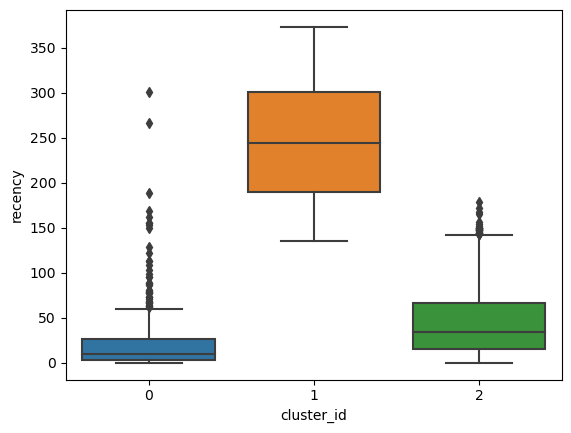

In [46]:
# plot
sns.boxplot(x='cluster_id', y='recency', data=grouped_df)

### interpretation of the box plot in relation to 'Recency':

Recency, as defined in RFM analysis, represents the number of days since the last purchase.

1. **Cluster 1 (Blue Box)**
   - The median recency (the line inside the box) for this cluster is very low, indicating that customers in this group have made purchases very recently.
   - The interquartile range (IQR), represented by the height of the box, is quite narrow, meaning that the middle 50% of customers in this group have a similar, recent purchase history.
   - There are several outliers, suggesting that a few customers in this cluster have not made a purchase for a longer time than the majority.

2. **Cluster 2 (Orange Box)**
   - The median recency for this cluster is quite high, suggesting that it's been a while since customers in this group made a purchase.
   - The IQR is broad, indicating variability in the purchase history of these customers. Some may have bought items not too long ago, while others might have not purchased for an extended period.
   - There are no outliers at the top and bottom
   
3. **Cluster 3 (Green Box)**
   - The median recency is higher than Cluster 1 but lower than Cluster 2, positioning this group in the middle in terms of how recently they've made a purchase.
   - The IQR is relatively narrow, suggesting that the middle 50% of these customers have a somewhat consistent purchase history.
   - There are a few outliers at the top, representing customers with a more extended gap since their last purchase.

**General Interpretation**: 
- Customers in Cluster 1 are the most recent purchasers, possibly indicating a segment of loyal or active customers.
- Customers in Cluster 2, on the other hand, have the longest gaps since their last purchase, identifying them as potentially lapsed or at-risk customers.
- Customers in Cluster 3 fall between the two, suggesting they're somewhat active but not as recent in their purchases as those in Cluster 0.

Given this analysis, businesses could consider different engagement strategies for each cluster. For instance, Cluster 1 could be targeted with new product announcements or loyalty rewards, Cluster 2 might benefit from re-engagement campaigns or special offers to encourage them to make a purchase, and Cluster 3 might be approached with periodic promotions to ensure they remain engaged.

<AxesSubplot: xlabel='cluster_id', ylabel='frequency'>

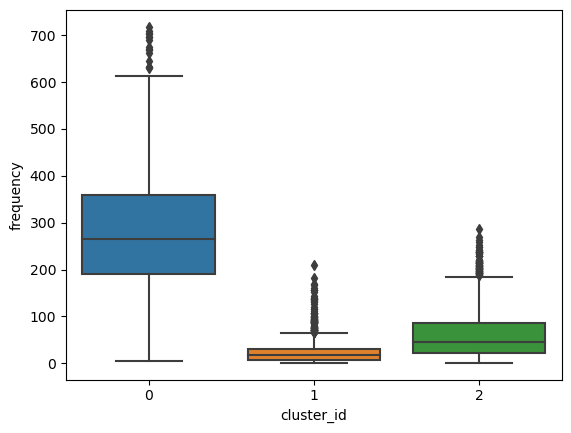

In [47]:
# plot
sns.boxplot(x='cluster_id', y='frequency', data=grouped_df)

### interpretation of the box plot in relation to 'Frequency':

Frequency, as defined in RFM analysis, represents the number of transactions made by customers.

1. **Cluster 1 (Blue Box)**
   - The median frequency (the line inside the box) for this cluster is relatively high, suggesting that customers in this group conduct transactions more often.
   - The interquartile range (IQR), represented by the height of the box, indicates variability in transaction numbers among customers in this cluster. While many are consistent in their purchase behavior, some differ noticeably.
   - The several outliers at the top suggest that a few customers in this group have significantly more transactions than the majority.

2. **Cluster 2 (Orange Box)**
   - The median frequency for this cluster is notably low, indicating that customers in this group transact less often compared to the other clusters.
   - The IQR is quite narrow, suggesting that the majority of these customers have similar, low transaction numbers.
   - There are some outliers above the box, indicating that a minority of customers in this cluster transact more often than the majority.

3. **Cluster 3 (Green Box)**
   - The median frequency of this cluster is higher than Cluster 1 but lower than Cluster 0.
   - The IQR is also narrow, indicating consistency in the transaction numbers for most customers in this cluster.
   - There are a few outliers above the box, suggesting that some customers in this cluster have more transactions than the central majority.

**General Interpretation**: 
- Customers in Cluster 1 are the most frequent buyers, indicating a segment of highly active or loyal customers.
- Customers in Cluster 2 transact the least often, identifying them as infrequent or occasional buyers.
- Customers in Cluster 3 are in between, indicating they have a moderate transaction frequency.

For businesses, understanding these clusters' behaviors is crucial. High-frequency buyers (Cluster 1) might be targeted with loyalty programs or exclusive offers to maintain their engagement. Infrequent buyers (Cluster 2) could be targeted with promotions or campaigns to increase their purchase frequency. The moderate-frequency group (Cluster 3) could be approached with strategies to further boost their engagement and move them towards becoming high-frequency buyers.

## Hierarchical Clustering

The hierarchical clustering involves 2 basic steps:

- Creating the dendrogram
- Cutting the dendrogram at an appropriate level

In [48]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [49]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,1


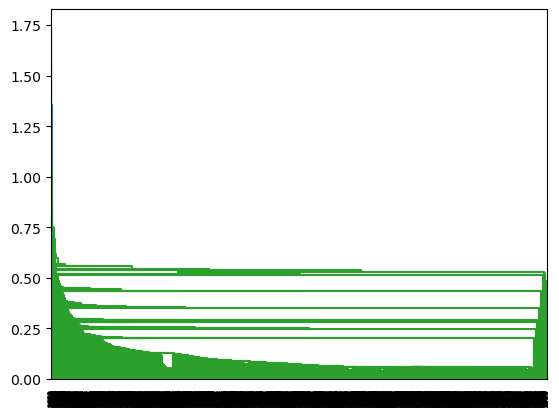

In [50]:
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

You can't read the results because it doesn't look like a dendogram at all. The reason is that we have used single linkage and in the single linkage the problem is that it takes the two closest points in two clusters and defined that as the distance.

As you can clearly see, single linkage doesn't produce a good enough result for us to analyse the clusters. Hence, we need to go ahead and utilise the complete linkage method and then analyse the clusters once again.

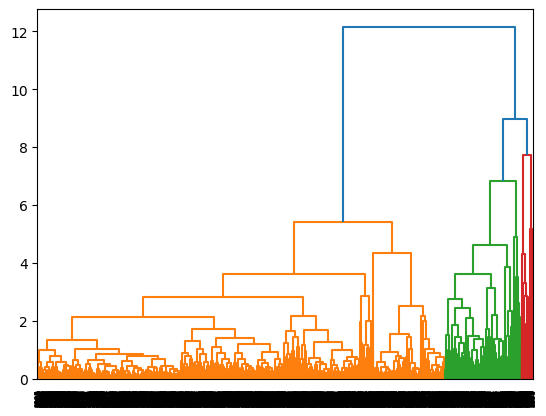

In [51]:
# complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

Here, you don't have to prespecify the value of K, the number of clusters. You can just create a dendogram and look at how many clusters you can create. You can create 2, 3, 4 and that also depends on the final business objective. 

It will assign cluster ids between 0, 1, and 2. For example, red data points may be assigned cluster number 0, green data points may be assigned cluster number 1, and orange data points may be assigned cluster number 2.

In [52]:
# Now we want to create 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [53]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,1,0
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,2,0
3,12349.0,1757.55,73,18,2,0
4,12350.0,334.40,17,309,1,0


<AxesSubplot: xlabel='cluster_labels', ylabel='recency'>

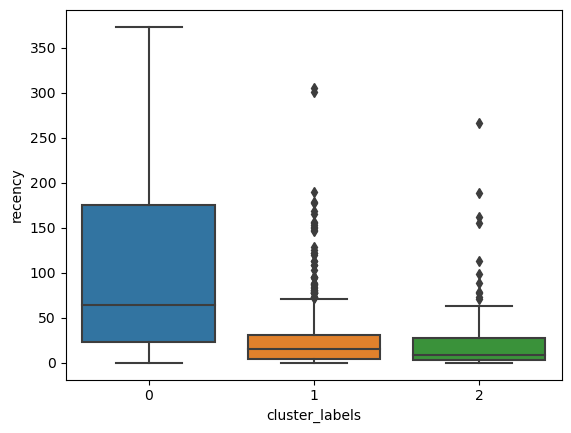

In [54]:
# plots
sns.boxplot(x='cluster_labels', y='recency', data=grouped_df)

<AxesSubplot: xlabel='cluster_labels', ylabel='frequency'>

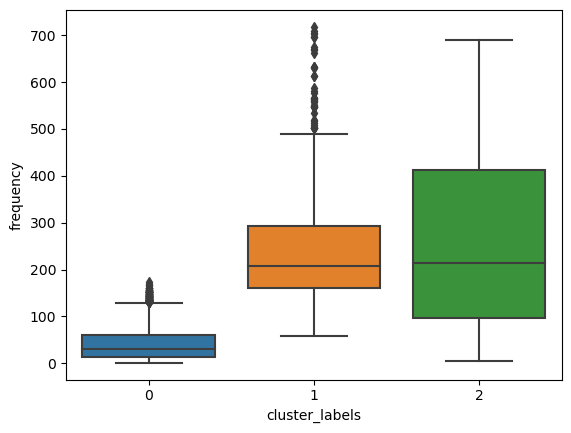

In [55]:
# plots
sns.boxplot(x='cluster_labels', y='frequency', data=grouped_df)



**Cluster 1 (Blue)**
- Customers in this cluster have the lowest transaction frequency relative to the other clusters.
- The median frequency is close to 50, suggesting half of the customers in this cluster have conducted this number of transactions or fewer.
- The interquartile range is narrow, indicating a smaller variation in transaction numbers among these customers.
- Some outliers are present, especially one slightly above the box, implying that a few customers in this cluster have transacted more frequently than most.

**Cluster 2 (Orange)**
- Customers in this cluster have a moderate transaction frequency.
- The median frequency is around 220, which means half of these customers have conducted this number of transactions or fewer.
- The interquartile range is wider than Cluster 0, suggesting a broader spread or variation in the number of transactions among these customers.
- Several outliers are present above the box, highlighting some customers who transact significantly more often than the majority in this cluster.

**Cluster 3 (Green)**
- Customers in this cluster exhibit the highest transaction frequency.
- The median frequency is around 230, indicating half of these customers have conducted this number of transactions or fewer.
- The interquartile range is quite broad, showcasing the variability in transaction numbers among these high-frequency customers.
- There are no significant outliers in this cluster, suggesting a more consistent behavior among these customers.

**Overall Interpretation**:
- **Cluster 1** comprises customers who transact the least frequently.
- **Cluster 2** consists of customers with a moderate transaction frequency with a few who transact much more often.
- **Cluster 3** represents customers who transact the most frequently.

From a business perspective, understanding frequency can help tailor marketing efforts. Customers in Cluster 1 might be targeted with re-engagement campaigns to increase their transaction frequency. In contrast, those in Cluster 3 might be rewarded for their loyalty and high engagement. Cluster 2 customers offer a mixed bag, where some might be nudged to transact more, while others might be consolidated with loyalty offers.

<AxesSubplot: xlabel='cluster_labels', ylabel='amount'>

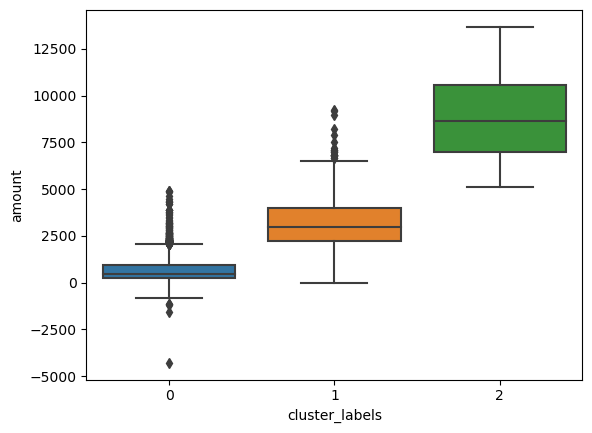

In [56]:
# plots
sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)

The box plot provides insights into the distribution of the "Amount" values across three different clusters. In RFM analysis, "Amount" or "Monetary" refers to the total revenue contributed by transactions. Here's how to interpret the box plot in relation to the 'Amount':

**Cluster 1 (Blue)**
- Customers in this cluster have the lowest monetary contribution compared to the other clusters.
- The median amount is slightly above 0, suggesting that half of the customers in this cluster have spent this amount or less.
- The interquartile range is narrow, indicating consistent spending behavior among the customers in this cluster.
- There are outliers present both above and below the box, especially one customer who has spent a significantly negative amount, possibly indicating returns or refunds.

**Cluster 2 (Orange)**
- Customers in this cluster have a moderate monetary contribution.
- The median amount is around 2500, indicating that half of the customers in this cluster have contributed this amount or less.
- The interquartile range is relatively wide, showing variability in the amount spent by these customers.
- There are outliers on the upper side, signifying a few customers who have spent significantly more than the majority in this cluster.

**Cluster 3 (Green)**
- Customers in this cluster have the highest monetary contribution.
- The median amount is just below 10,000, suggesting that half of these customers have spent this amount or less.
- The interquartile range is relatively wide, indicating variability among these high-spending customers.
- While there's a noticeable spread in amounts, there are no significant outliers.

**Overall Interpretation**:
- **Cluster 1** represents customers with the lowest monetary contribution, with some exceptions in the form of outliers.
- **Cluster 2** represents customers with a moderate monetary contribution.
- **Cluster 3** consists of the highest spending customers.

Based on this analysis, businesses might decide to allocate more resources and offer premium services or loyalty programs to customers in Cluster 3 due to their high spending behavior. Conversely, marketing strategies might focus on upselling or cross-selling to customers in Cluster 1 and 2 to increase their monetary contributions.

Three clusters are represented enough of different customer segment. 

Any more than three clusters doesn't look like a good idea because even with three clusters there is still not a lot of difference between cluster 1 and cluster 2(frequency). It might basically looks unnecessary. 

The advantage of hierarchical clustering is that you don't need to play around K, but the advantage of K-means clustering is that it is far more simpler technique to use in many cases.